In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import random
import os

# 0. DIRECTORY SETUP
BASE_DIR = r"D:\Anaconda\Projects\TransformerArchitecture"
DATA_DIR = os.path.join(BASE_DIR, "data")
MODEL_SAVE_PATH = os.path.join(BASE_DIR, "trained_mnist_transformer.pth")

# Ensure your custom directories exist
os.makedirs(DATA_DIR, exist_ok=True)

# Setup device to use the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Name: NVIDIA GeForce GTX 1650


In [2]:
# 1. THE ARCHITECTURE
class DistanceBiasedAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        
        self.distance_weight = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        B, seq_len, _ = x.shape
        
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)
        
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.d_model ** 0.5)
        
        indices = torch.arange(seq_len, device=x.device)
        distance_matrix = torch.abs(indices.unsqueeze(0) - indices.unsqueeze(1))
        
        scores = scores - (distance_matrix * self.distance_weight)
        
        attn_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, v)
        
        return output

class MNISTTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(1, 64) 
        
        self.attn1 = DistanceBiasedAttention(d_model=64)
        self.norm1a = nn.LayerNorm(64)
        self.ffn1 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.norm1b = nn.LayerNorm(64)
        
        self.attn2 = DistanceBiasedAttention(d_model=64)
        self.norm2a = nn.LayerNorm(64)
        self.ffn2 = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.norm2b = nn.LayerNorm(64)
        
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, h*w, 1) 
        x = self.embedding(x)
        
        attn_out = self.attn1(x)
        x = self.norm1a(x + attn_out)
        ffn_out = self.ffn1(x)
        x = self.norm1b(x + ffn_out)

        attn_out = self.attn2(x)
        x = self.norm2a(x + attn_out)
        ffn_out = self.ffn2(x)
        x = self.norm2b(x + ffn_out)
        
        x = x.mean(dim=1) 
        return self.classifier(x)

In [3]:
# 2. DATA LOADING & TRAINING
BATCH_SIZE = 128
EPOCHS = 10 
LEARNING_RATE = 0.001

print(f"\nDownloading/Loading MNIST Data to {DATA_DIR}...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root=DATA_DIR, train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=True, transform=transform)

# pin_memory=True keeps RAM-to-VRAM transfers fast
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

model = MNISTTransformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print(f"\nStarting Training on {device}...\n" + "-"*40)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    start_time = time.time()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        if batch_idx % 150 == 0:
            print(f"   Epoch {epoch+1} | Batch {batch_idx:03d}/{len(train_loader)} | Loss: {loss.item():.4f}")

    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()

    train_acc = 100 * correct / total
    test_acc = 100 * test_correct / test_total
    epoch_time = time.time() - start_time
    
    print("-" * 40)
    print(f" Epoch {epoch+1} Summary:")
    print(f"   Time     : {epoch_time:.1f}s")
    print(f"   Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")
    print("-" * 40 + "\n")

# SAVE THE TRAINED WEIGHTS
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model weights successfully saved to: {MODEL_SAVE_PATH}")


Downloading/Loading MNIST Data to D:\Anaconda\Projects\TransformerArchitecture\data...


100.0%
100.0%
100.0%
100.0%



Starting Training on cuda...
----------------------------------------
   Epoch 1 | Batch 000/469 | Loss: 2.2810
   Epoch 1 | Batch 150/469 | Loss: 1.8813
   Epoch 1 | Batch 300/469 | Loss: 1.6000
   Epoch 1 | Batch 450/469 | Loss: 1.4979
----------------------------------------
 Epoch 1 Summary:
   Time     : 148.9s
   Train Acc: 34.73% | Test Acc: 46.52%
----------------------------------------

   Epoch 2 | Batch 000/469 | Loss: 1.4785
   Epoch 2 | Batch 150/469 | Loss: 1.4166
   Epoch 2 | Batch 300/469 | Loss: 1.2491
   Epoch 2 | Batch 450/469 | Loss: 1.1843
----------------------------------------
 Epoch 2 Summary:
   Time     : 143.5s
   Train Acc: 55.89% | Test Acc: 62.47%
----------------------------------------

   Epoch 3 | Batch 000/469 | Loss: 1.0743
   Epoch 3 | Batch 150/469 | Loss: 0.9476
   Epoch 3 | Batch 300/469 | Loss: 0.9811
   Epoch 3 | Batch 450/469 | Loss: 0.8998
----------------------------------------
 Epoch 3 Summary:
   Time     : 143.0s
   Train Acc: 65.19% 


--- TESTING THE SAVED MODEL ---
Successfully loaded trained weights from D:\Anaconda\Projects\TransformerArchitecture\trained_mnist_transformer.pth!
Image Index: #7024
 The AI guessed: 3
 The actual answer was: 3


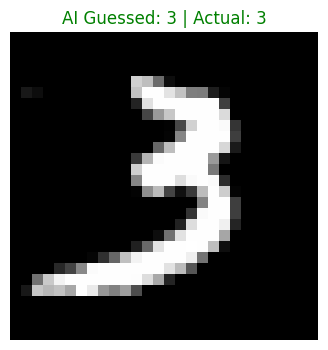

In [5]:
# 3. TESTING THE SAVED MODEL
print("\n--- TESTING THE SAVED MODEL ---")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=False, transform=transform) 

# Initialize the architecture
model = MNISTTransformer().to(device)

# Load the weights from your Anaconda projects folder
try:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print(f"Successfully loaded trained weights from {MODEL_SAVE_PATH}!")
except FileNotFoundError:
    print(f"Error: Could not find model weights at {MODEL_SAVE_PATH}. Did you run the training cell?")
    
model.eval()

# Pick a random image
random_index = random.randint(0, len(test_dataset) - 1)
single_image, true_label = test_dataset[random_index]

# THE FIX: Just add a batch dimension so the shape is [1, 1, 28, 28]
# and move it to your GTX 1650
batched_image = single_image.unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = model(batched_image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()
    
print(f"Image Index: #{random_index}")
print(f" The AI guessed: {predicted_label}")
print(f" The actual answer was: {true_label}")

# Display the image
plt.figure(figsize=(4,4))
plt.imshow(single_image.squeeze().cpu(), cmap='gray')

color = 'green' if predicted_label == true_label else 'red'
plt.title(f"AI Guessed: {predicted_label} | Actual: {true_label}", color=color)
plt.axis('off')
plt.show()


--- TESTING THE SAVED MODEL ---
Successfully loaded trained weights from D:\Anaconda\Projects\TransformerArchitecture\trained_mnist_transformer.pth!
Image Index: #8688
 The AI guessed: 7
 The actual answer was: 7


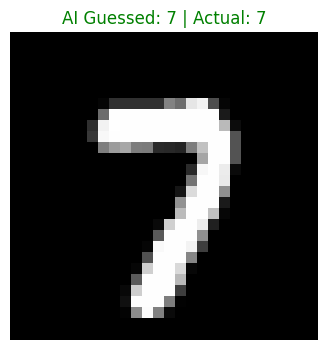

In [6]:
# 3. TESTING THE SAVED MODEL
print("\n--- TESTING THE SAVED MODEL ---")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=False, transform=transform) 

# Initialize the architecture
model = MNISTTransformer().to(device)

# Load the weights from your Anaconda projects folder
try:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print(f"Successfully loaded trained weights from {MODEL_SAVE_PATH}!")
except FileNotFoundError:
    print(f"Error: Could not find model weights at {MODEL_SAVE_PATH}. Did you run the training cell?")
    
model.eval()

# Pick a random image
random_index = random.randint(0, len(test_dataset) - 1)
single_image, true_label = test_dataset[random_index]

# THE FIX: Just add a batch dimension so the shape is [1, 1, 28, 28]
# and move it to your GTX 1650
batched_image = single_image.unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = model(batched_image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()
    
print(f"Image Index: #{random_index}")
print(f" The AI guessed: {predicted_label}")
print(f" The actual answer was: {true_label}")

# Display the image
plt.figure(figsize=(4,4))
plt.imshow(single_image.squeeze().cpu(), cmap='gray')

color = 'green' if predicted_label == true_label else 'red'
plt.title(f"AI Guessed: {predicted_label} | Actual: {true_label}", color=color)
plt.axis('off')
plt.show()


--- TESTING THE SAVED MODEL ---
Successfully loaded trained weights from D:\Anaconda\Projects\TransformerArchitecture\trained_mnist_transformer.pth!
Image Index: #2625
 The AI guessed: 2
 The actual answer was: 2


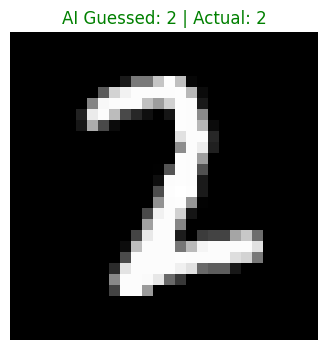

In [7]:
# 3. TESTING THE SAVED MODEL
print("\n--- TESTING THE SAVED MODEL ---")

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = datasets.MNIST(root=DATA_DIR, train=False, download=False, transform=transform) 

# Initialize the architecture
model = MNISTTransformer().to(device)

# Load the weights from your Anaconda projects folder
try:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print(f"Successfully loaded trained weights from {MODEL_SAVE_PATH}!")
except FileNotFoundError:
    print(f"Error: Could not find model weights at {MODEL_SAVE_PATH}. Did you run the training cell?")
    
model.eval()

# Pick a random image
random_index = random.randint(0, len(test_dataset) - 1)
single_image, true_label = test_dataset[random_index]

# THE FIX: Just add a batch dimension so the shape is [1, 1, 28, 28]
# and move it to your GTX 1650
batched_image = single_image.unsqueeze(0).to(device)

# Get prediction
with torch.no_grad():
    output = model(batched_image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()
    
print(f"Image Index: #{random_index}")
print(f" The AI guessed: {predicted_label}")
print(f" The actual answer was: {true_label}")

# Display the image
plt.figure(figsize=(4,4))
plt.imshow(single_image.squeeze().cpu(), cmap='gray')

color = 'green' if predicted_label == true_label else 'red'
plt.title(f"AI Guessed: {predicted_label} | Actual: {true_label}", color=color)
plt.axis('off')
plt.show()